# Self Organizing Maps

A self-organizing map (SOM) is a type of artificial neural network (ANN) that is trained using unsupervised learning to produce a low-dimensional (typically two-dimensional), discretized representation of the input space of the training samples and displays similarities among data.

The basic principle behind these maps is competitive learning, unlike other ANN which are based on backpropogation.

SOM was introduced by Finnish professor Teuvo Kohonen in the 1980s is sometimes called a Kohonen map.

![SOM](som.png)

With SOM, clustering is performed by having several data units compete for an object in the reduced 2D space. The 2D space consists of nodes, where each node represents a weight vector with the same dimensions as the input vector. This is important because the similarity between these weight vectors and the data points is the base for this approach.

There are numerous ways to determine the similarity, however, the most commonly used method is the Euclidean Distance and/or Consine Distance. 

Each data from data set recognizes themselves by competeting for representation. SOM mapping steps starts from initializing the weight vectors. From there a sample vector (data point) is selected randomly and the map of weight vectors is searched to find which weight best represents that sample. Each weight vector has neighboring weights that are close to it. The weight that is chosen is rewarded by being able to become more like that randomly selected sample vector. The neighbors of that weight are also rewarded by being able to become more like the chosen sample vector. From this step the number of neighbors and how much each weight can learn decreases over time. This whole process is repeated a large number of times. 

The algorithm for SOM is summarized as follows:


- Each node's weights are initialized.
- A vector is chosen at random from the set of training data.
- Every node is examined to calculate which one's weights are most like the input vector. The winning node is commonly known as the Best Matching Unit (BMU).
- Then the neighbourhood of the BMU is calculated. The amount of neighbors decreases over time.
- The winning weight is rewarded with becoming more like the sample vector. The nighbors also become more like the sample vector. The closer a node is to the BMU, the more its weights get altered and the farther away the neighbor is from the BMU, the less it learns.
- Repeat step 2 for N iterations.


# Example 1 : Clustering RGB colors

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [72]:
raw_data = np.random.randint(0, 255, (3, 100))

## Intializing the Network

In [74]:
network_dimensions = np.array([5, 5])
n_iterations = 10000
init_learning_rate = 0.01

In [75]:
m = raw_data.shape[0]
n = raw_data.shape[1]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

In [73]:
def scale_data(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data

data = scale_data(raw_data)

In [76]:
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

## Find Best Matching Unit

In [2]:
def find_bmu(t, net, m):

    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)


# Decay Radius, Learning Rate

In [3]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [4]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

# Measure Influence on Neighborhood

![normal](normal.jpg)

In [5]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

# Weight Update
![title](weight_update.png)

In [81]:
for i in range(n_iterations):
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # check if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # apply the new weight
                net[x, y, :] = new_w.reshape(1, 3)

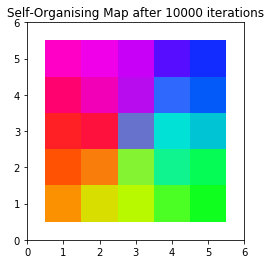

In [82]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()

# Example 2 : Clustering Iris Data

In [182]:
from sklearn.datasets import load_iris

In [183]:
raw_data = load_iris()

In [259]:
data = raw_data['data']
label = raw_data['target']

In [262]:
data[0:5, :], label[0:5]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]),
 array([0, 0, 0, 0, 0]))

In [58]:
network_dimensions = np.array([10, 10])
n_iterations = 10000
init_learning_rate = 0.005

In [59]:
m = data.shape[1]
n = data.shape[0]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

#data = data.transpose()

In [60]:
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

In [61]:
for i in range(n_iterations):
    
    # select a training example at random
    t = data[np.random.randint(0, n), :].reshape(np.array([1, m]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(1, m)
            # get the 2-D distance
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # check if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # apply the new weight
                net[x, y, :] = new_w.reshape(1, m)

In [62]:
def get_node_distance_matrix(datapoint, som_array):
    dist_mat = np.empty(dtype=np.float64, shape=[som_array.shape[0], som_array.shape[1]])
    for i in range(som_array.shape[0]):
        for j in range (som_array.shape[1]):
            dist_mat[i, j] = np.sum((datapoint - som_array[i][j]) ** 2)
    return dist_mat

In [63]:
def get_bmu(datapoint, som_array):

    a = get_node_distance_matrix(
        datapoint, som_array)

    return np.argwhere(a == np.min(a))[0]

def get_bmus(X, som_array=None):

    bmus = None
    bmus = [np.array(get_bmu(dp, som_array)) for dp in X]
    return np.array(bmus)


In [64]:
bmus = get_bmus(data, net)

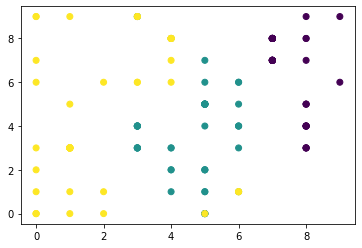

In [65]:
plt.scatter(bmus[:,0], bmus[:,1], c=label)

In [69]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap)

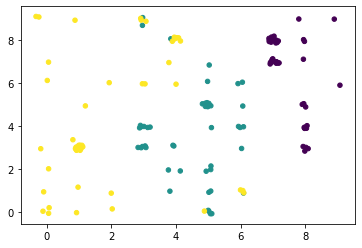

In [70]:
jitter(bmus[:,0], bmus[:,1], c=label)

## Example 3: Moons

In [184]:
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans

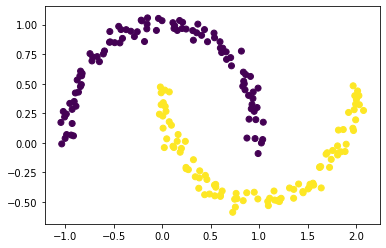

In [185]:
data, cluster = make_moons(n_samples=200, noise=0.05)
plt.scatter(data[:,0], data[:,1], c=cluster)

In [186]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

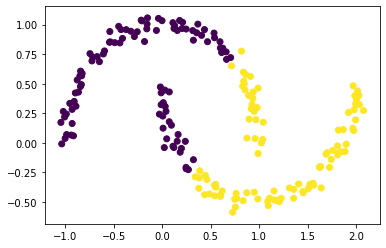

In [187]:
plt.scatter(data[:,0], data[:,1], c=kmeans.labels_)

In [244]:
network_dimensions = np.array([12, 12])
n_iterations = 12000
init_learning_rate = 0.005

In [245]:
m = data.shape[1]
n = data.shape[0]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

#data = data.transpose()

In [246]:
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

In [247]:
for i in range(n_iterations):
    
    # select a training example at random
    t = data[np.random.randint(0, n), :].reshape(np.array([1, m]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(1, m)
            # get the 2-D distance
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # check if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # apply the new weight
                net[x, y, :] = new_w.reshape(1, m)

In [248]:
def get_node_distance_matrix(datapoint, som_array):
    dist_mat = np.empty(dtype=np.float64, shape=[som_array.shape[0], som_array.shape[1]])
    for i in range(som_array.shape[0]):
        for j in range (som_array.shape[1]):
            dist_mat[i, j] = np.sum((datapoint - som_array[i][j]) ** 2)
    return dist_mat

In [249]:
def get_bmu(datapoint, som_array):

    a = get_node_distance_matrix(
        datapoint, som_array)

    return np.argwhere(a == np.min(a))[0]

def get_bmus(X, som_array=None):

    bmus = None
    bmus = [np.array(get_bmu(dp, som_array)) for dp in X]
    return np.array(bmus)


In [250]:
bmus = get_bmus(data, net)

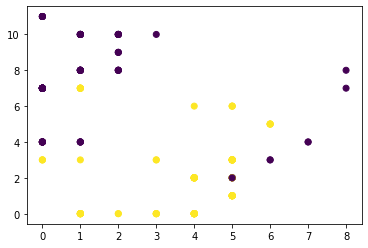

In [251]:
plt.scatter(bmus[:,0], bmus[:,1], c=cluster)

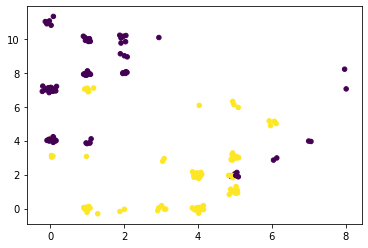

In [252]:
jitter(bmus[:,0], bmus[:,1], c=cluster)

In [253]:
kmeans = KMeans(n_clusters=2, random_state=45).fit(bmus)

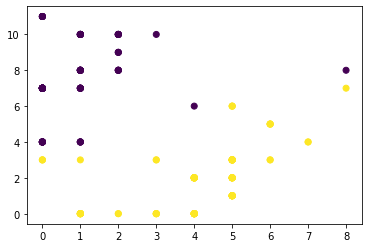

In [254]:
plt.scatter(bmus[:,0], bmus[:,1], c=kmeans.labels_)

In [255]:
new_clusters = np.empty(shape=(data.shape[0]))
i = 0
for i in range(data.shape[0]):
    new_clusters[i] = kmeans.labels_[i]
    #new_clusters[i] = bmu_labels[i]

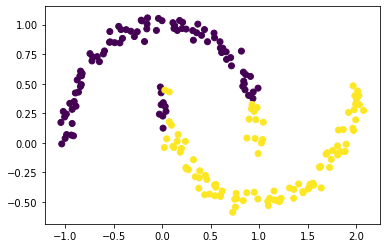

In [256]:
plt.scatter(data[:,0], data[:,1], c=new_clusters)

# Thanks